In [ ]:
import pandas as pd
domain = ["Iraqi", "Levantine", "Gulf", "Nile_Basin", "North_Africa"]


data_Gulf = pd.read_csv("../Data/data_Gulf_preprocessed_train", sep="\t")
data_Iraqi = pd.read_csv("../Data/data_Iraqi_preprocessed_train", sep="\t")
data_Levantine = pd.read_csv("../Data/data_Levantine_preprocessed_train", sep="\t")
data_Nile_Basin = pd.read_csv("../Data/data_Nile_Basin_preprocessed_train", sep="\t")
data_North_Africa = pd.read_csv("../Data/data_North_Africa_preprocessed_train", sep="\t")
corpus = {"Gulf": data_Gulf,
          "Iraqi": data_Iraqi,
          "Levantine": data_Levantine,
          "Nile_Basin":data_Nile_Basin,
          "North_Africa": data_North_Africa}
for label, data in corpus.items():
  data["length"] = [len(data.source_lang[i].split()) for i in range(data.shape[0]) ]
  data.sort_values("length", ascending = False, inplace=True)

In [ ]:
data_Gulf.shape,data_Iraqi.shape,data_Levantine.shape,data_Nile_Basin.shape,data_North_Africa.shape

((9659, 5), (2922, 5), (17002, 5), (9946, 5), (29245, 5))

In [ ]:
#arabert, adaslxml, camelarabert, aragpt2,
#first test with one model , arabert
import torch
import time
from transformers import *
import numpy as np
from collections import Counter

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-large-arabertv02")

In [ ]:
words = []
for i in range(data_Nile_Basin.source_lang.shape[0]):
  words += [x for x in ((data_Nile_Basin.source_lang[i].split()))]

In [ ]:

# BertModel, BertTokenizer
def encode_with_transformers(corpus, models_to_use = ["aubmindlab/bert-large-arabertv02"]):
  for model_class, tokenizer_class, model_name in MODELS:
      if model_name not in models_to_use:
          continue
      print('encoding with {}...'.format(model_name))
      model_to_states[model_name] = {}
      model_to_states[model_name]['states'] = []
      model_to_states[model_name]['sents'] = []

      # Load pretrained model/tokenizer
      tokenizer = tokenizer_class.from_pretrained(model_name)
      model = model_class.from_pretrained(model_name)
      model.to(torch.device('cuda'))

      # Encode text
      start = time.time()
      for sentence in corpus:
          model_to_states[model_name]['sents'].append(sentence)
          input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=128)])  # Add special tokens takes care of adding [CLS], [SEP], <s>... tokens in the right way for each model.
          input_ids = input_ids.to(torch.device('cuda'))
          with torch.no_grad():
              output = model(input_ids)
              last_hidden_states = output[0]

              # avg pool last hidden layer
              squeezed = last_hidden_states.squeeze(dim=0)
              masked = squeezed[:input_ids.shape[1],:]
              avg_pooled = masked.mean(dim=0)
              model_to_states[model_name]['states'].append(avg_pooled.cpu())

      end = time.time()
      print('encoded with {} in {} seconds'.format(model_name, end - start))
      np_tensors = [np.array(tensor) for tensor in model_to_states[model_name]['states']]
      model_to_states[model_name]['states'] = np.stack(np_tensors)
      return model_to_states

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix( y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    uniq = unique_labels(y_true, y_pred)
    classes = np.array(classes)[uniq]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    classes = [c for c in classes]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # Show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # And label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()



    return plt

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import gensim

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


print(__doc__)

colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray', 'black']

def make_ellipses(gmm, ax, clusters_to_classes):
    """
    Adds Ellipses to ax according to the gmm clusters.
    """
    for n in sorted(list(clusters_to_classes.keys())):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        class_id = clusters_to_classes[n]
        class_color = colors[class_id]
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=class_color, linewidth=0)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.4)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')


def map_clusters_to_classes_by_majority(y_train, y_train_pred):
    """
    Maps clusters to classes by majority to compute the Purity metric.
    """
    cluster_to_class = {}
    for cluster in np.unique(y_train_pred):
        # run on indices where this is the cluster
        original_classes = []
        for i, pred in enumerate(y_train_pred):
            if pred == cluster:
                original_classes.append(y_train[i])
        # take majority
        cluster_to_class[cluster] = max(set(original_classes), key = original_classes.count)
    return cluster_to_class



Automatically created module for IPython interactive environment


In [ ]:
def fit_gmm(name_to_embeddings, class_names, first_principal_component_shown=0,
            last_principal_component_shown=1, clusters=5, header='', plot=True, pca=True,
            confusion=False, examples_per_class = 2000):
    """
    Fits a GMM to the embeddings in name_to_embeddings where each name represents a dataset.
    """
    all_states = []
    all_sents = []
    num_classes = len(class_names)
    if last_principal_component_shown <= first_principal_component_shown:
        raise Exception('first PCA component must be smaller than the 2nd')

    # Concatenate the data to one matrix
    for label in class_names:
        all_states.append(name_to_embeddings[label]['states'][0:examples_per_class])
        all_sents += name_to_embeddings[label]['sents']
    concat_all_embs = np.concatenate(all_states)

    # Compute PCA
    if pca:
        pca = PCA(n_components=1+last_principal_component_shown)
        pca_data = pca.fit_transform(concat_all_embs)[:, list(range(first_principal_component_shown,last_principal_component_shown+1))]
    else:
        pca_data = concat_all_embs

    pca_labels = []
    for i in range(len(class_names)):
        for j in range(examples_per_class):
            pca_labels.append(i)
    pca_labels = np.array(pca_labels)

    # Do not split the data - train=test=all (unsupervised evaluation)
    train_index = list(range(0, pca_data.shape[0]))
    test_index = list(range(0, pca_data.shape[0]))

    X_train = pca_data[train_index]
    y_train = pca_labels[train_index]
    X_test = pca_data[test_index]
    y_test = pca_labels[test_index]

    n_classes = len(np.unique(y_train))
    if clusters > 0:
        n_clusters = clusters
    else:
        n_clusters = n_classes

    # Can try GMMs using different types of covariances, we use full.
    estimators = {cov_type: GaussianMixture(n_components=n_clusters,
                  covariance_type=cov_type, max_iter=150, random_state=0)
                  for cov_type in ['full']} #'spherical', 'diag', 'tied',

    n_estimators = len(estimators)

    # Configure the plot
    if plot:
        main_plot = plt.figure(figsize=(8, 8))
        plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05, left=.01, right=.99)

    best_accuracy = 0
    for index, (name, estimator) in enumerate(estimators.items()):

        # train the GMM
        estimator.fit(X_train)

        # create the plots
        if plot:
            h = plt.subplot(1, 1, 1)

            # Plot the train data with dots
            for n, color in enumerate(colors[:num_classes]):
                data = pca_data[[index for index in range(len(pca_labels)) if pca_labels[index] == n]]
                plt.scatter(data[:, 0], data[:, 1], s=20, marker='o', color=color,
                            label=class_names[n].replace('_dev',''), alpha = 0.3)

        # predict the cluster ids for train
        y_train_pred = estimator.predict(X_train)

        # predict the cluster ids for test
        y_test_pred = estimator.predict(X_test)

        # map clusters to classes by majority of true class in cluster
        clusters_to_classes = map_clusters_to_classes_by_majority(y_train, y_train_pred)
        y_pred_by_majority = np.array([clusters_to_classes[pred] for pred in y_train_pred])
        # plot confusion matrix, error analysis
        if confusion:
            
            y_pred_by_majority = np.array([clusters_to_classes[pred] for pred in y_train_pred])
            plot = plot_confusion_matrix(y_train, y_pred_by_majority, class_names)

        # Calculate the Purity metric
        count=0
        for i, pred in enumerate(y_train_pred):
            if clusters_to_classes[pred] == y_train[i]:
                count += 1
        train_accuracy = float(count)/len(y_train_pred) * 100

        correct_count=0
        for i, pred in enumerate(y_test_pred):
            if clusters_to_classes[pred] == y_test[i]:
                correct_count += 1
        test_accuracy = float(correct_count)/len(y_test_pred) * 100

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy

        if plot:
            make_ellipses(estimator, h, clusters_to_classes)
            plt.xticks(())
            plt.yticks(())
            leg = plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=18))
            for lh in leg.legendHandles:
                lh.set_alpha(1)
                lh._sizes = [60]

    if plot:
        plt.suptitle(header)
       
        plt.show()

    return best_accuracy, y_train, y_pred_by_majority, class_names

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# CAMeL-Lab/bert-base-arabic-camelbert-da

from collections import defaultdict
from collections import Counter

model_name = "CAMeL-Lab/bert-base-arabic-camelbert-da"
MODELS = [(BertModel, BertTokenizer, model_name)]

model_to_states = {}
models_to_use = ["CAMeL-Lab/bert-base-arabic-camelbert-da"]
corpus = {"Gulf": data_Gulf,
          "Iraqi": data_Iraqi,
          "Levantine": data_Levantine,
          "Nile_Basin":data_Nile_Basin,
          "North_Africa": data_North_Africa}
# corpus = {"Gulf": data_Gulf,
#           "Iraqi": data_Iraqi,
#           "Levantine": data_Levantine,
#           "Nile":data_Nile,
#           "North_Africa": data_North}
# corpus = {"Gulf": data_Gulf,
#           "North": data_North

# }
model_to_domain_to_encodings_new_camel_2 = defaultdict(dict)
for domain_name in corpus:
    print('encoding {} with transformers...'.format(domain_name))
    data = corpus[domain_name]
 
    res = encode_with_transformers(data.source_lang[:2], models_to_use)
    for model_name in models_to_use:
        model_to_domain_to_encodings_new_camel_2[model_name][domain_name] = res[model_name]

In [ ]:
model_to_domain_to_encodings_new_camel_2["CAMeL-Lab/bert-base-arabic-camelbert-da"]["Gulf"]["states"].shape

(2, 768)

<ipython-input-23-09da8ce11b3d>:38: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
<ipython-input-76-5708614820dd>:125: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


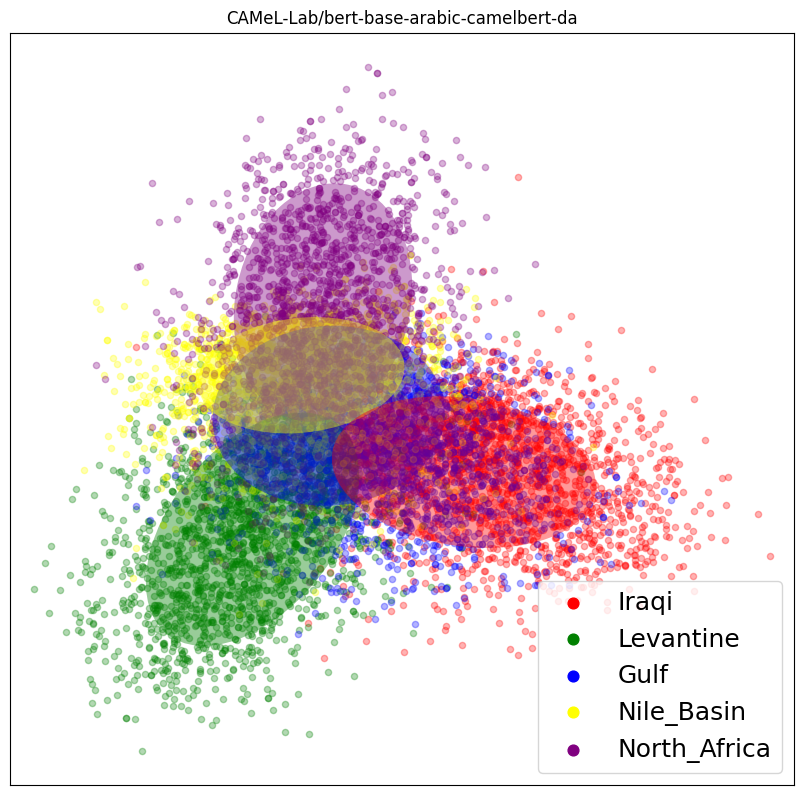

CAMeL-Lab/bert-base-arabic-camelbert-da	63.83 (±0.04)


In [ ]:
# cluster the new split dev data
# domains = [ 'Iraqi', 'Levantine','Gulf', 'Nile', 'North_Africa']
# model_to_domain_to_encodings_new trained on all dataset
# model_to_domain_to_encodings_new_camel_2 trained on 2900 sentences of each data
domain = ["Iraqi", "Levantine", "Gulf", "Nile_Basin", "North_Africa"]

first_principal = 1
last_principal = 20
num_clusters = 5
num_experiments = 3
use_pca = True


model_to_accuracies = defaultdict(list)
for i in range(num_experiments):
    if i == num_experiments - 1:
        plot = True
        confusion = True
    else:
        plot = False
        confusion = False

    for model_name in model_to_domain_to_encodings_new_camel_2:
        accuracy, y_train, y_pred, class_names = fit_gmm(model_to_domain_to_encodings_new_camel_2[model_name], domain,
                                first_principal_component_shown = first_principal,
                                last_principal_component_shown = last_principal,
                                clusters = num_clusters,
                                header = model_name, plot=plot, pca = use_pca, confusion=False,
                           examples_per_class = 2000)
        model_to_accuracies[model_name].append(accuracy)

for model_name in model_to_accuracies:
    print('{0}\t{1:.2f} (±{2:.2f})'.format(model_name,
                               np.mean(np.array(model_to_accuracies[model_name])),
                               np.std(np.array(model_to_accuracies[model_name]))))

Confusion matrix, without normalization
[[1645   36  266   15   38]
 [  68 1498  363   27   44]
 [1195  110  575   73   47]
 [  70  116  403 1349   62]
 [  56  229  342   63 1310]]


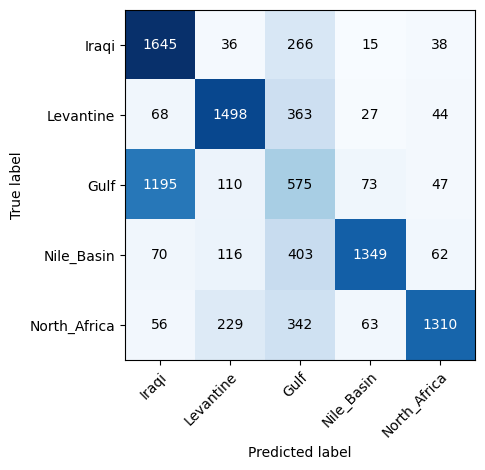

In [ ]:
plt = plot_confusion_matrix(y_train, y_pred, class_names)
plt.show()

In [ ]:
data_domain =[]
data_camel = model_to_domain_to_encodings_new_camel_2['CAMeL-Lab/bert-base-arabic-camelbert-da']
for label in domain:

  data = pd.DataFrame(data ={"sent": [data_camel[label]["sents"][i] for i in range(len(data_camel[label]["sents"]))],
                                      "states": ([np.array(data_camel[label]["states"][i]) for i in range(data_camel[label]["states"].shape[0])])} )
  data["label"] = [label for _ in range(data.shape[0])]
  data_domain.append(data)

data_1= pd.concat([data_domain[0], data_domain[1]], ignore_index = True)
data_2 = pd.concat([data_domain[2], data_domain[3]], ignore_index = True)
data_3= pd.concat([data_1, data_domain[4]], ignore_index = True)
data = pd.concat([data_2, data_3], ignore_index = True)

data.to_csv("./camel_data_clustering", index = 'False')

In [ ]:
data = pd.read_csv("./arabert_data_clustering" )

In [ ]:
len(data["states"][0])

12480

In [ ]:
from collections import defaultdict
from collections import Counter
# base_path_new = '/home/nlp/aharonr6/git/domain-robustness/data/de-en/new_split'
# file_paths_new = {
#                 'medical_dev':base_path_new + '/medical/dev.en',
#                 'it_dev':base_path_new + '/it/dev.en',
#                 'koran_dev':base_path_new + '/koran/dev.en',
#                 'subtitles_dev':base_path_new + '/subtitles/dev.en',
#                 'law_dev': base_path_new + '/law/dev.en'
#              }
model_name = "aubmindlab/bert-large-arabertv02"
MODELS = [(BertModel, BertTokenizer, model_name)]

model_to_states = {}
models_to_use = ["aubmindlab/bert-large-arabertv02"]
corpus = {"Gulf": data_Gulf,
          "Iraqi": data_Iraqi,
          "Levantine": data_Levantine,
          "Nile_Basin":data_Nile_Basin,
          "North_Africa": data_North_Africa}
# corpus = {"Gulf": data_Gulf,
#           "Iraqi": data_Iraqi,
#           "Levantine": data_Levantine,
#           "Nile":data_Nile,
#           "North_Africa": data_North}
# corpus = {"Gulf": data_Gulf,
#           "North": data_North

# }
model_to_domain_to_encodings_new_arabert = defaultdict(dict)
for domain_name in corpus:
    print('encoding {} with transformers...'.format(domain_name))
    data = corpus[domain_name]
    # counter = Counter(open(file_path).readlines())
    # print(counter.most_common(10))
    # lines = list(set(open(file_path).readlines())) # eliminate duplicate sentences
    # print('found {} lines'.format(len(lines)))
    res = encode_with_transformers(data.source_lang[:2], models_to_use)
    for model_name in models_to_use:
        model_to_domain_to_encodings_new_arabert[model_name][domain_name] = res[model_name]

encoding Gulf with transformers...
encoding with aubmindlab/bert-large-arabertv02...


tokenizer_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/tokenizer.json


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-large-arabertv02",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421

model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/model.safetensors
Some weights of the model checkpoint at aubmindlab/bert-large-arabertv02 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

encoded with aubmindlab/bert-large-arabertv02 in 0.07450509071350098 seconds
encoding Iraqi with transformers...
encoding with aubmindlab/bert-large-arabertv02...


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/model.safetensors
Some weights of the model checkpo

encoded with aubmindlab/bert-large-arabertv02 in 0.13353371620178223 seconds
encoding Levantine with transformers...
encoding with aubmindlab/bert-large-arabertv02...


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/config.json
Model config BertConfig {

encoded with aubmindlab/bert-large-arabertv02 in 0.11659908294677734 seconds
encoding Nile_Basin with transformers...
encoding with aubmindlab/bert-large-arabertv02...


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/model.safetensors
Some weights of the model checkpo

encoded with aubmindlab/bert-large-arabertv02 in 0.07273030281066895 seconds
encoding North_Africa with transformers...
encoding with aubmindlab/bert-large-arabertv02...


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--aubmindlab--bert-large-arabertv02/snapshots/12c9edc789ec5b60444ebb8046de0dde57421fe2/config.json
Model config BertConfig {

encoded with aubmindlab/bert-large-arabertv02 in 0.08336591720581055 seconds


In [ ]:
model_to_domain_to_encodings_new_arabert["aubmindlab/bert-large-arabertv02"]["Gulf"]["states"].shape

(2, 1024)

<ipython-input-23-09da8ce11b3d>:38: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
<ipython-input-76-5708614820dd>:125: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


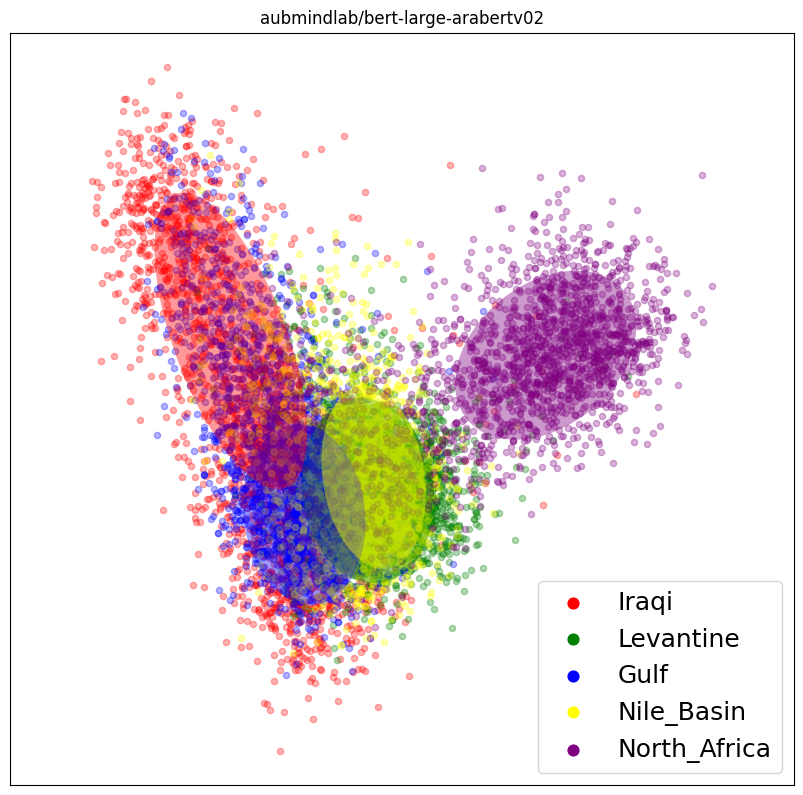

aubmindlab/bert-large-arabertv02	65.14 (±0.02)


In [ ]:
# cluster the new split dev data
# domains = [ 'Iraqi', 'Levantine','Gulf', 'Nile', 'North_Africa']
domain = ["Iraqi", "Levantine", "Gulf", "Nile_Basin", "North_Africa"]
first_principal = 1
last_principal = 20
num_clusters = 5
num_experiments = 3
use_pca = True

# 5 clusters - roberta-large - 88.22 (±0.49) - 1/50/5
# 10 clusters - roberta-large - 85.84 (±0.31) - 1/50/10
# 15 clusters - bert-large-cased - 87.25 (±1.19) - 1/50/15

model_to_accuracies = defaultdict(list)
for i in range(num_experiments):
    if i == num_experiments - 1:
        plot = True
        confusion = True
    else:
        plot = False
        confusion = False

    for model_name in model_to_domain_to_encodings_new_arabert:
        accuracy, y_train, y_pred, class_names = fit_gmm(model_to_domain_to_encodings_new_arabert[model_name], domain,
                                first_principal_component_shown = first_principal,
                                last_principal_component_shown = last_principal,
                                clusters = num_clusters,
                                header = model_name, plot=plot, pca = use_pca, confusion=False,
                           examples_per_class = 2000)
        model_to_accuracies[model_name].append(accuracy)

for model_name in model_to_accuracies:
    print('{0}\t{1:.2f} (±{2:.2f})'.format(model_name,
                               np.mean(np.array(model_to_accuracies[model_name])),
                               np.std(np.array(model_to_accuracies[model_name]))))

Confusion matrix, without normalization
[[ 967  213  769   17   34]
 [  84 1615  162  105   34]
 [ 777  220  931   62   10]
 [ 123  131  261 1478    7]
 [  36  180  172   87 1525]]


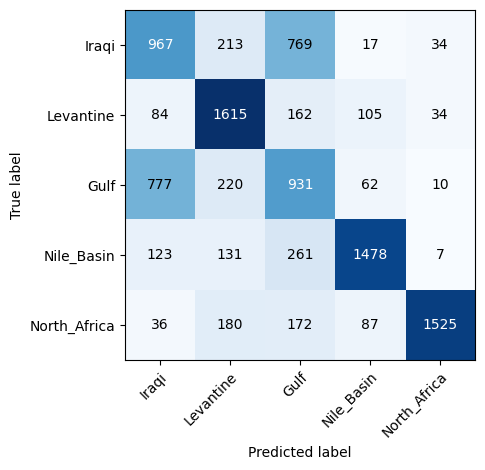

In [ ]:
plt = plot_confusion_matrix(y_train, y_pred, class_names)
plt.show()

In [ ]:
data_domain =[]
data_camel = model_to_domain_to_encodings_new_arabert['aubmindlab/bert-large-arabertv02']
for label in domain:

  data = pd.DataFrame(data ={"sent": [data_camel[label]["sents"][i] for i in range(len(data_camel[label]["sents"]))],
                                      "states": ([np.array(data_camel[label]["states"][i]) for i in range(data_camel[label]["states"].shape[0])])} )
  data["label"] = [label for _ in range(data.shape[0])]
  data_domain.append(data)

data_1= pd.concat([data_domain[0], data_domain[1]], ignore_index = True)
data_2 = pd.concat([data_domain[2], data_domain[3]], ignore_index = True)
data_3= pd.concat([data_1, data_domain[4]], ignore_index = True)
data = pd.concat([data_2, data_3], ignore_index = True)

data.to_csv("./arabert_data_clustering", index = 'False')

In [ ]:
# CAMeL-Lab/bert-base-arabic-camelbert-mix

from collections import defaultdict
from collections import Counter
# base_path_new = '/home/nlp/aharonr6/git/domain-robustness/data/de-en/new_split'
# file_paths_new = {
#                 'medical_dev':base_path_new + '/medical/dev.en',
#                 'it_dev':base_path_new + '/it/dev.en',
#                 'koran_dev':base_path_new + '/koran/dev.en',
#                 'subtitles_dev':base_path_new + '/subtitles/dev.en',
#                 'law_dev': base_path_new + '/law/dev.en'
#              }
model_name = "UBC-NLP/MARBERTv2"
MODELS = [(BertModel, BertTokenizer, model_name)]

model_to_states = {}
models_to_use = ["UBC-NLP/MARBERTv2"]
corpus = {"Gulf": data_Gulf,
          "Iraqi": data_Iraqi,
          "Levantine": data_Levantine,
          "Nile_Basin":data_Nile_Basin,
          "North_Africa": data_North_Africa}
# corpus = {"Gulf": data_Gulf,
#           "Iraqi": data_Iraqi,
#           "Levantine": data_Levantine,
#           "Nile":data_Nile,
#           "North_Africa": data_North}
# corpus = {"Gulf": data_Gulf,
#           "North": data_North

# }
model_to_domain_to_encodings_new_camel_mix = defaultdict(dict)
for domain_name in corpus:
    print('encoding {} with transformers...'.format(domain_name))
    data = corpus[domain_name]
    # counter = Counter(open(file_path).readlines())
    # print(counter.most_common(10))
    # lines = list(set(open(file_path).readlines())) # eliminate duplicate sentences
    # print('found {} lines'.format(len(lines)))
    res = encode_with_transformers(data.source_lang[:2900], models_to_use)
    for model_name in models_to_use:
        model_to_domain_to_encodings_new_camel_mix[model_name][domain_name] = res[model_name]

In [ ]:
model_to_domain_to_encodings_new_camel_mix["UBC-NLP/MARBERTv2"]["Gulf"]["states"].shape

(2, 768)

In [ ]:
data_domain =[]
data_camel = model_to_domain_to_encodings_new_camel_mix['UBC-NLP/MARBERTv2']
for label in domain:

  data = pd.DataFrame(data ={"sent": [data_camel[label]["sents"][i] for i in range(len(data_camel[label]["sents"]))],
                                      "states": ([np.array(data_camel[label]["states"][i]) for i in range(data_camel[label]["states"].shape[0])])} )
  data["label"] = [label for _ in range(data.shape[0])]
  data_domain.append(data)

data_1= pd.concat([data_domain[0], data_domain[1]], ignore_index = True)
data_2 = pd.concat([data_domain[2], data_domain[3]], ignore_index = True)
data_3= pd.concat([data_1, data_domain[4]], ignore_index = True)
data = pd.concat([data_2, data_3], ignore_index = True)

data.to_csv("./arabert_data_clustering", index = 'False')

<ipython-input-9-09da8ce11b3d>:38: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
<ipython-input-10-5708614820dd>:125: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


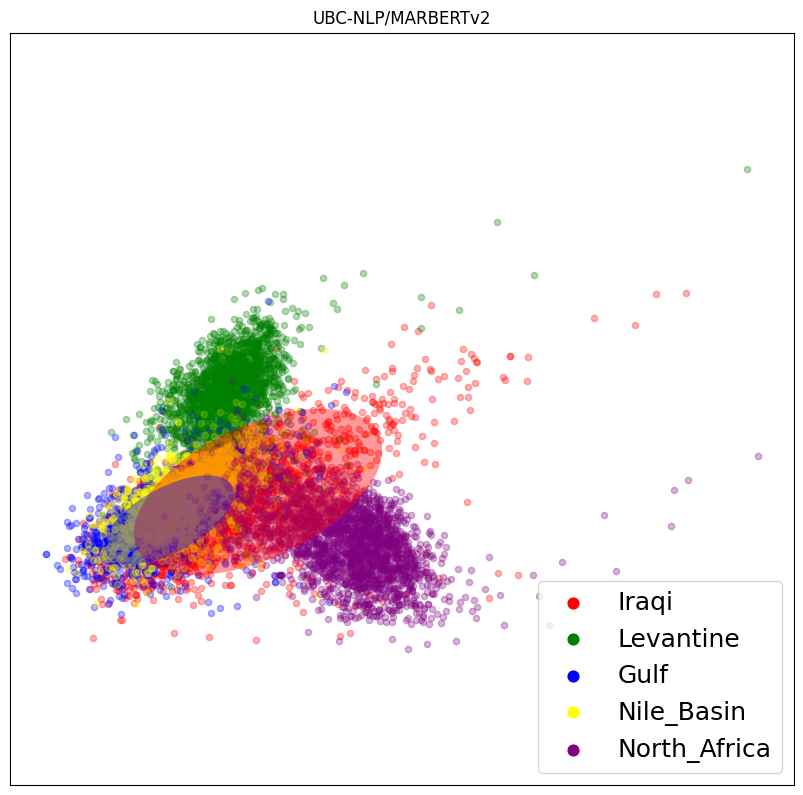

UBC-NLP/MARBERTv2	79.58 (±4.19)


In [ ]:
# cluster the new split dev data
# domains = [ 'Iraqi', 'Levantine','Gulf', 'Nile', 'North_Africa']
domain = ["Iraqi", "Levantine", "Gulf", "Nile_Basin", "North_Africa"]
first_principal = 1
last_principal = 20
num_clusters = 5
num_experiments = 3
use_pca = True

# 5 clusters - roberta-large - 88.22 (±0.49) - 1/50/5
# 10 clusters - roberta-large - 85.84 (±0.31) - 1/50/10
# 15 clusters - bert-large-cased - 87.25 (±1.19) - 1/50/15

model_to_accuracies = defaultdict(list)
for i in range(num_experiments):
    if i == num_experiments - 1:
        plot = True
        confusion = True
    else:
        plot = False
        confusion = False

    for model_name in model_to_domain_to_encodings_new_camel_mix:
        accuracy, y_train, y_pred, class_names = fit_gmm(model_to_domain_to_encodings_new_camel_mix[model_name], domain,
                                first_principal_component_shown = first_principal,
                                last_principal_component_shown = last_principal,
                                clusters = num_clusters,
                                header = model_name, plot=plot, pca = use_pca, confusion=False,
                           examples_per_class = 2000)
        model_to_accuracies[model_name].append(accuracy)

for model_name in model_to_accuracies:
    print('{0}\t{1:.2f} (±{2:.2f})'.format(model_name,
                               np.mean(np.array(model_to_accuracies[model_name])),
                               np.std(np.array(model_to_accuracies[model_name]))))

Confusion matrix, without normalization
[[ 723   49 1164   47   17]
 [ 116 1771   24   76   13]
 [ 268   58 1498  168    8]
 [  67   28   76 1822    7]
 [  95   12   12   37 1844]]


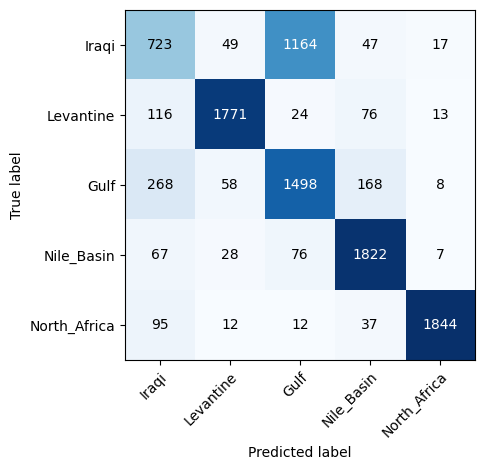

In [ ]:
plt = plot_confusion_matrix(y_train, y_pred, class_names)
plt.show()

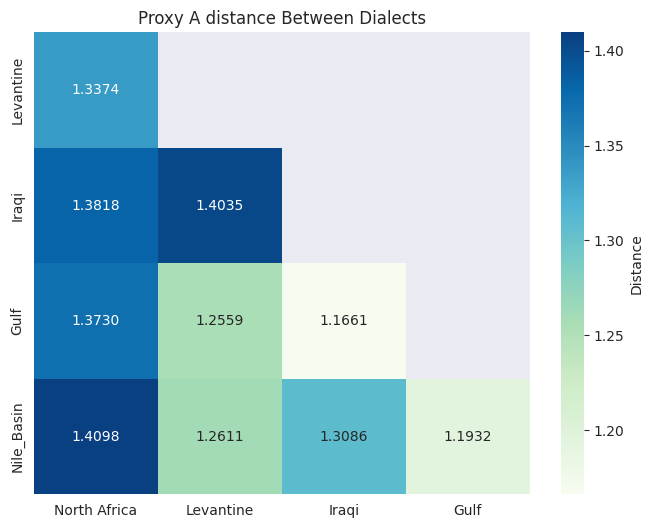

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
# Define the dialects
dialects = ["North Africa", "Levantine", "Iraqi", "Gulf", "Nile_Basin"]

# Initialize a 2D array with large value (e.g., 999) to fill the diagonal later.
distances = np.full((len(dialects)-1, len(dialects)-1), 0, dtype=float)

# Fill the distances
# distances[0, :] = [0.88, 1.3373818390848777, 1.3817530438078935,
#                    1.372998634159065, 1.4097834619075997]
# distances[1, :] = [1.3373818390848777, 0.88, 1.403466966858228, 1.2559331232141164,
#                    1.2611209746013037]
# distances[4, :] = [1.4097834619075997,1.2611209746013037,
#                    1.3086368087432072, 1.1931868922616706, 0.88]
# distances[3, :] = [1.372998634159065, 1.2559331232141164,  1.1660638745469356, 0.88, 1.1931868922616706]
# distances[2, :] = [ 1.3817530438078935,1.403466966858228, 0.88,
#                    1.1660638745469356, 1.3086368087432072]


distances[0, :] = [1.3373818390848777, np.nan, 1.403466966858228, 1.2559331232141164
                   ]
distances[3, :] = [1.4097834619075997,1.2611209746013037,
                   1.3086368087432072, 1.1931868922616706]
distances[2, :] = [1.372998634159065, 1.2559331232141164,
                   1.1660638745469356, np.nan]
distances[1, :] = [ 1.3817530438078935,1.403466966858228, np.nan,
                   1.1660638745469356]
# np.fill_diagonal(distances, np.nan)
# Since distance is symmetric (dist(A,B) = dist(B,A)), mirror the matrix across its diagonal
# for i in range(len(dialects)-1):
#     for j in range(i+1, len(dialects)-1):
#         distances[j, i] = distances[i, j]
# formatted_distances = np.array([[f"{value:.3f}" for value in row] for row in distances])
# Plot the heatmap
mask = np.triu(np.ones((4,4), dtype= bool))
np.fill_diagonal(mask, False)
plt.figure(figsize=(8,6))

sns.heatmap(distances, annot=True, cmap="GnBu",
            xticklabels=["North Africa", "Levantine", "Iraqi", "Gulf"],
            yticklabels=["Levantine", "Iraqi", "Gulf", "Nile_Basin"], mask = mask,
             cbar_kws={'label': 'Distance'}, fmt=".4f")
plt.title("Proxy A distance Between Dialects")
plt.show()


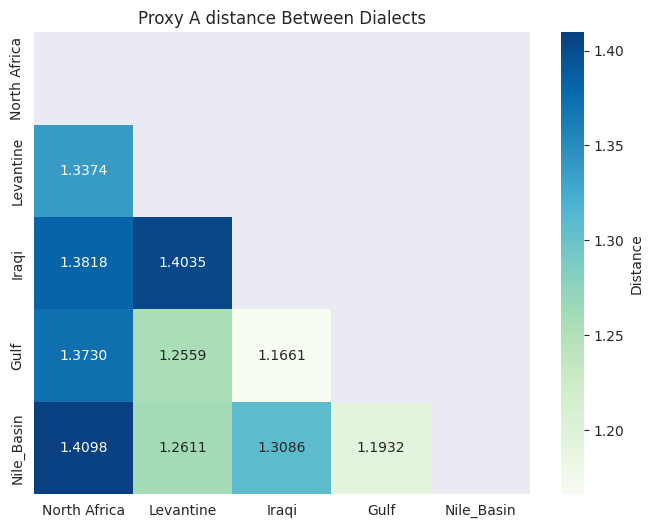

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
# Define the dialects
dialects = ["North Africa", "Levantine", "Iraqi", "Gulf", "Nile_Basin"]

# Initialize a 2D array with large value (e.g., 999) to fill the diagonal later.
distances = np.full((len(dialects), len(dialects)), 0, dtype=float)

# Fill the distances
distances[0, :] = [0.88, 1.3373818390848777, 1.3817530438078935,
                   1.372998634159065, 1.4097834619075997]
distances[1, :] = [1.3373818390848777, 0.88, 1.403466966858228, 1.2559331232141164,
                   1.2611209746013037]
distances[4, :] = [1.4097834619075997,1.2611209746013037,
                   1.3086368087432072, 1.1931868922616706, 0.88]
distances[3, :] = [1.372998634159065, 1.2559331232141164,  1.1660638745469356, 0.88, 1.1931868922616706]
distances[2, :] = [ 1.3817530438078935,1.403466966858228, 0.88,
                   1.1660638745469356, 1.3086368087432072]


# distances[0, :] = [1.3373818390848777, np.nan, 1.403466966858228, 1.2559331232141164
#                    ]
# distances[3, :] = [1.4097834619075997,1.2611209746013037,
#                    1.3086368087432072, 1.1931868922616706]
# distances[2, :] = [1.372998634159065, 1.2559331232141164,
#                    1.1660638745469356, np.nan]
# distances[1, :] = [ 1.3817530438078935,1.403466966858228, np.nan,
#                    1.1660638745469356]
# np.fill_diagonal(distances, np.nan)
# Since distance is symmetric (dist(A,B) = dist(B,A)), mirror the matrix across its diagonal
# for i in range(len(dialects)-1):
#     for j in range(i+1, len(dialects)-1):
#         distances[j, i] = distances[i, j]
# formatted_distances = np.array([[f"{value:.3f}" for value in row] for row in distances])
# Plot the heatmap
# mask = np.triu(np.ones((4,4), dtype= bool))
# np.fill_diagonal(mask, False)
plt.figure(figsize=(8,6))
mask = np.triu(np.ones((5,5,), dtype= bool))
sns.heatmap(distances, annot=True, cmap="GnBu",
            xticklabels=dialects,
            yticklabels=dialects, mask = mask,
             cbar_kws={'label': 'Distance'}, fmt=".4f")
plt.title("Proxy A distance Between Dialects")
plt.show()


In [ ]:
mask = np.triu(np.ones_like(distances, dtype=bool))
mask

array([[ True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True],
       [False, False,  True,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False, False,  True]])

In [ ]:
mask = np.triu(np.ones((4,4), dtype= bool))
np.fill_diagonal(mask, False)
mask

array([[False,  True,  True,  True],
       [False, False,  True,  True],
       [False, False, False,  True],
       [False, False, False, False]])

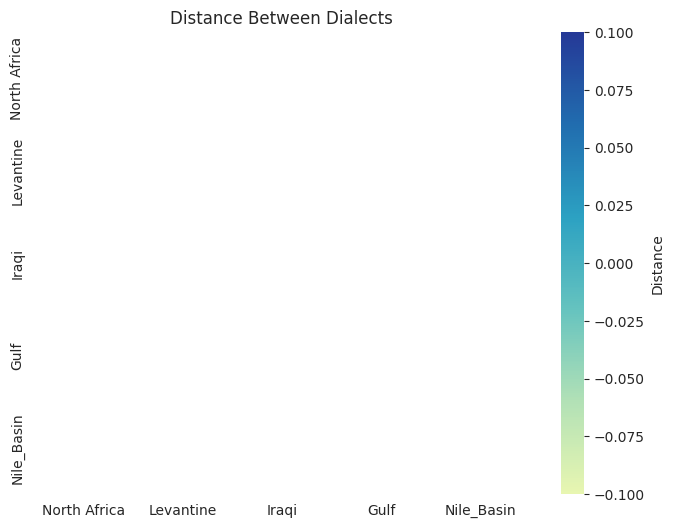

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Define the dialects
dialects = ["North Africa", "Levantine", "Iraqi", "Gulf", "Nile_Basin"]

# Initialize a 2D array with NaN values.
distances = np.full((len(dialects), len(dialects)), np.nan)

# Fill the distances
distances[0, 1:] = [1.3373818390848777, 1.3817530438078935, 1.372998634159065, 1.4097834619075997]
distances[1, 2:] = [1.403466966858228, 1.2559331232141164, 1.2611209746013037]

# Create a mask for the upper triangle of the matrix
mask = np.triu(np.ones_like(distances, dtype=bool))

# Format the distances to have 3 decimal points for the heatmap annotations
formatted_distances = np.array([[f"{value:.3f}" if not np.isnan(value) else "" for value in row] for row in distances])

# Set 'bad' color in colormap to black
cmap = mcolors.LinearSegmentedColormap.from_list("custom", sns.color_palette("YlGnBu").as_hex())
cmap.set_bad(color='white')

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(distances, annot=formatted_distances, cmap=cmap, fmt='', xticklabels=dialects, yticklabels=dialects, mask=mask, cbar_kws={'label': 'Distance'})
plt.title("Distance Between Dialects")
plt.show()


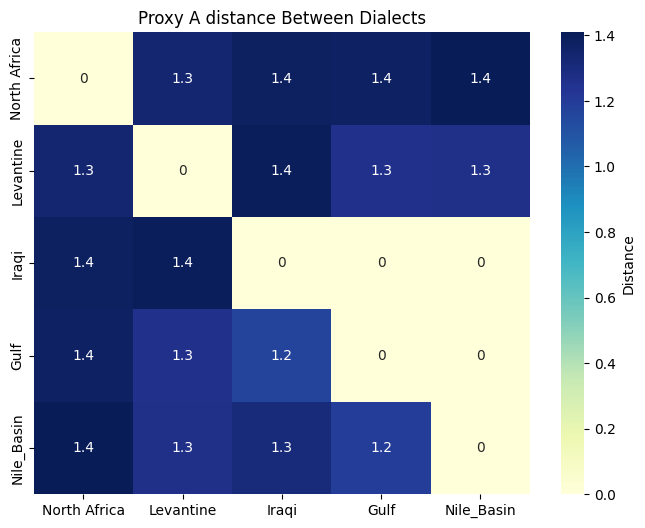

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(distances, annot=True, cmap='YlGnBu', xticklabels=dialects, yticklabels=dialects, cbar_kws={'label': 'Distance'})
plt.title("Proxy A distance Between Dialects")
plt.show()


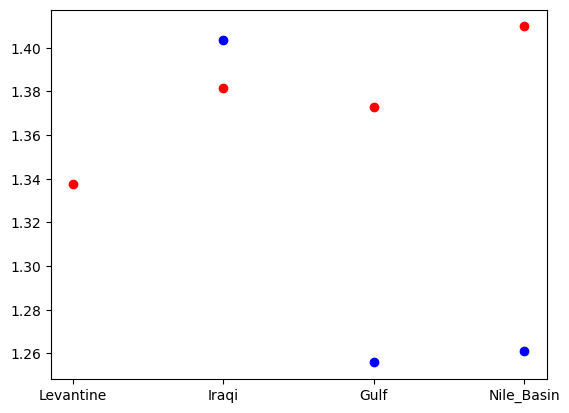

In [ ]:
import matplotlib.pyplot as plt
y = [1.3373818390848777, 1.3817530438078935, 1.372998634159065, 1.4097834619075997]
x=["Levantine" , "Iraqi","Gulf",
               "Nile_Basin"]
z =  ["Iraqi", "Gulf", "Nile_Basin"]
f = [1.403466966858228, 1.2559331232141164, 1.2611209746013037]

plt.plot(x,y, "ro")
plt.plot(z,f, "bo")

In [ ]:
len(model_to_domain_to_encodings_new['aubmindlab/bert-large-arabertv02']["Gulf"]["sents"])

10000

In [ ]:
model_to_domain = model_to_domain_to_encodings_new['aubmindlab/bert-large-arabertv02']

In [ ]:
model_to_domain = defaultdict(dict)

In [ ]:
model_to_domain['aubmindlab/bert-large-arabertv02'] = model_to_domain_to_encodings_new['aubmindlab/bert-large-arabertv02']

In [ ]:
len(model_to_domain['aubmindlab/bert-large-arabertv02']["Iraq"]['sents'])

6000

In [ ]:
model_to_domain['aubmindlab/bert-large-arabertv02']['Gulf'] = model_to_domain_to_encodings_new['aubmindlab/bert-large-arabertv02']['Gulf']

In [ ]:
model_to_domain['aubmindlab/bert-large-arabertv02']['North'] = model_to_domain_to_encodings_new['aubmindlab/bert-large-arabertv02']['North']

In [ ]:
# cluster the new split dev data
domains = ['Gulf', 'North']
first_principal = 1
last_principal = 3
num_clusters = 2
num_experiments = 1
use_pca = True

# 5 clusters - roberta-large - 88.22 (±0.49) - 1/50/5
# 10 clusters - roberta-large - 85.84 (±0.31) - 1/50/10
# 15 clusters - bert-large-cased - 87.25 (±1.19) - 1/50/15
model_name = "aubmindlab/bert-large-arabertv02"
model_to_accuracies = defaultdict(list)
for i in range(num_experiments):
    if i == num_experiments - 1:
        plot = True
        confusion = True
    else:
        plot = False
        confusion = False

    for model_name in model_to_domain:
        accuracy = fit_gmm(model_to_domain[model_name], domains,
                                first_principal_component_shown = first_principal,
                                last_principal_component_shown = last_principal,
                                clusters = num_clusters,
                                header = model_name, plot=plot, pca = use_pca, confusion=confusion,
                           examples_per_class = 6000)
        model_to_accuracies[model_name].append(accuracy)

for model_name in model_to_accuracies:
    print('{0}\t{1:.2f} (±{2:.2f})'.format(model_name,
                               np.mean(np.array(model_to_accuracies[model_name])),
                               np.std(np.array(model_to_accuracies[model_name]))))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from collections import defaultdict
from collections import Counter
# base_path_new = '/home/nlp/aharonr6/git/domain-robustness/data/de-en/new_split'
# file_paths_new = {
#                 'medical_dev':base_path_new + '/medical/dev.en',
#                 'it_dev':base_path_new + '/it/dev.en',
#                 'koran_dev':base_path_new + '/koran/dev.en',
#                 'subtitles_dev':base_path_new + '/subtitles/dev.en',
#                 'law_dev': base_path_new + '/law/dev.en'
#              }


model_name = "3ebdola/Dialectal-Arabic-XLM-R-Base"
MODELS = [(AutoModel, AutoTokenizer, model_name)]

model_to_states = {}
models_to_use = ["3ebdola/Dialectal-Arabic-XLM-R-Base"]

corpus = {"Gulf": data_Gulf,
          "Iraq": data_iraqi,
          "Levantine": data_Levantine,
          "Nile":data_Nile,
          "North": data_North}

model_to_domain_to_encodings_new = defaultdict(dict)
for domain_name in corpus:
    print('encoding {} with transformers...'.format(domain_name))
    data = corpus[domain_name]
    # counter = Counter(open(file_path).readlines())
    # print(counter.most_common(10))
    # lines = list(set(open(file_path).readlines())) # eliminate duplicate sentences
    # print('found {} lines'.format(len(lines)))
    res = encode_with_transformers(data.source_lang[:2000], models_to_use)
    for model_name in models_to_use:
        model_to_domain_to_encodings_new[model_name][domain_name] = res[model_name]

<ipython-input-5-329f3f22f1d4>:38: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],


Confusion matrix, without normalization
[[548 854   0 508  90]
 [449 941   0 462 148]
 [210 549   0 318 923]
 [480 679   0 744  97]
 [171 643   0 201 985]]


<ipython-input-5-329f3f22f1d4>:184: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


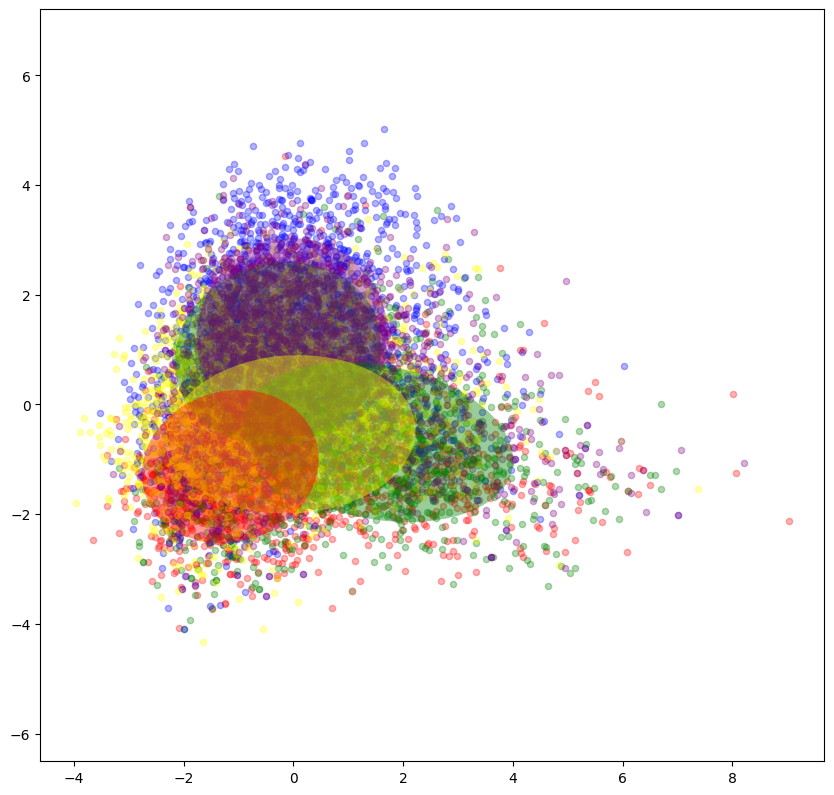

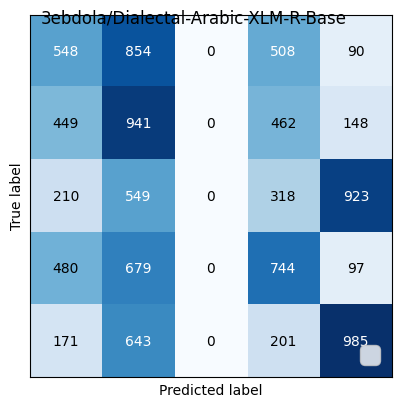

3ebdola/Dialectal-Arabic-XLM-R-Base	32.18 (±0.00)


In [ ]:
# cluster the new split dev data
domains = ['Gulf', 'Iraq', 'Levantine', 'Nile', 'North']
first_principal = 1
last_principal = 50
num_clusters = 5
num_experiments = 1
use_pca = True

# 5 clusters - roberta-large - 88.22 (±0.49) - 1/50/5
# 10 clusters - roberta-large - 85.84 (±0.31) - 1/50/10
# 15 clusters - bert-large-cased - 87.25 (±1.19) - 1/50/15

model_to_accuracies = defaultdict(list)
for i in range(num_experiments):
    if i == num_experiments - 1:
        plot = True
        confusion = True
    else:
        plot = False
        confusion = False

    for model_name in model_to_domain_to_encodings_new:
        accuracy = fit_gmm(model_to_domain_to_encodings_new[model_name], domains,
                                first_principal_component_shown = first_principal,
                                last_principal_component_shown = last_principal,
                                clusters = num_clusters,
                                header = model_name, plot=plot, pca = use_pca, confusion=confusion)
        model_to_accuracies[model_name].append(accuracy)

for model_name in model_to_accuracies:
    print('{0}\t{1:.2f} (±{2:.2f})'.format(model_name,
                               np.mean(np.array(model_to_accuracies[model_name])),
                               np.std(np.array(model_to_accuracies[model_name]))))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!pip install arabert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186459 sha256=a76c9d57c1cf8556a4aad2e0fc6718f0730b22029e57ca2513900211dfd9511f
  Stored in directory: /root/.cache/pip/wheels/10/f0/fd/4813b1177405693e8da9cdea839f0fb64fde161380e058c827
Successfully built emoji


In [ ]:
from collections import defaultdict
from transformers import GPT2TokenizerFast, pipeline
#for base and medium
from transformers import GPT2LMHeadModel
#for large and mega

from arabert.aragpt2.grover.modeling_gpt2 import GPT2LMHeadModel
from arabert.preprocess import ArabertPreprocessor
model_name = "aubmindlab/AraGPT2-mega"
MODELS = [(GPT2LMHeadModel, GPT2TokenizerFast, model_name)]

model_to_states = {}
models_to_use = ["aubmindlab/AraGPT2-mega"]

corpus = {"Gulf": data_Gulf,
          "Iraq": data_iraqi,
          "Levantine": data_Levantine,
          "Nile":data_Nile,
          "North": data_North}

model_to_domain_to_encodings_new = defaultdict(dict)
for domain_name in corpus:
    print('encoding {} with transformers...'.format(domain_name))
    data = corpus[domain_name]
    # counter = Counter(open(file_path).readlines())
    # print(counter.most_common(10))
    # lines = list(set(open(file_path).readlines())) # eliminate duplicate sentences
    # print('found {} lines'.format(len(lines)))
    res = encode_with_transformers(data.source_lang[:2000], models_to_use)
    for model_name in models_to_use:
        model_to_domain_to_encodings_new[model_name][domain_name] = res[model_name]

ModuleNotFoundError: ignored

<ipython-input-5-329f3f22f1d4>:38: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],


Confusion matrix, without normalization
[[   0  559  304  969  168]
 [   0  723  306  889   82]
 [   0  660  392  689  259]
 [   0  371  247 1341   41]
 [   0  278  314  209 1199]]


<ipython-input-5-329f3f22f1d4>:184: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


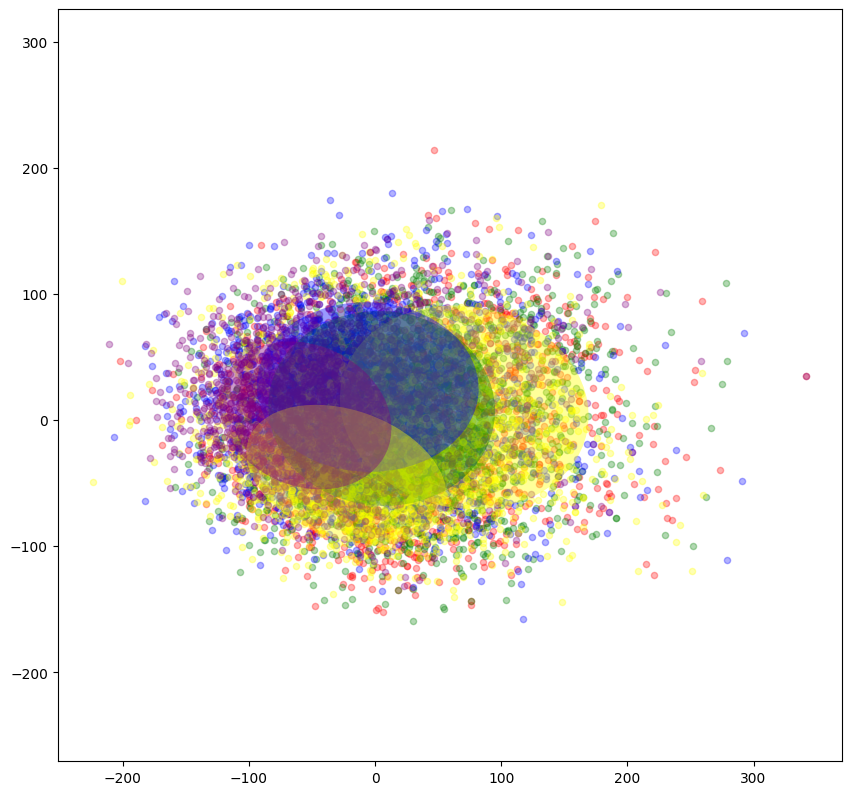

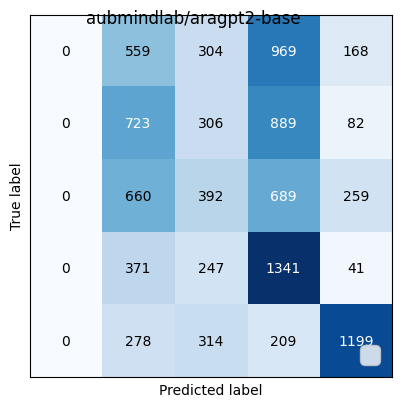

aubmindlab/aragpt2-base	36.55 (±0.00)


In [ ]:
# cluster the new split dev data
domains = ['Gulf', 'Iraq', 'Levantine', 'Nile', 'North']
first_principal = 1
last_principal = 50
num_clusters = 5
num_experiments = 1
use_pca = True

# 5 clusters - roberta-large - 88.22 (±0.49) - 1/50/5
# 10 clusters - roberta-large - 85.84 (±0.31) - 1/50/10
# 15 clusters - bert-large-cased - 87.25 (±1.19) - 1/50/15

model_to_accuracies = defaultdict(list)
for i in range(num_experiments):
    if i == num_experiments - 1:
        plot = True
        confusion = True
    else:
        plot = False
        confusion = False

    for model_name in model_to_domain_to_encodings_new:
        accuracy = fit_gmm(model_to_domain_to_encodings_new[model_name], domains,
                                first_principal_component_shown = first_principal,
                                last_principal_component_shown = last_principal,
                                clusters = num_clusters,
                                header = model_name, plot=plot, pca = use_pca, confusion=confusion)
        model_to_accuracies[model_name].append(accuracy)

for model_name in model_to_accuracies:
    print('{0}\t{1:.2f} (±{2:.2f})'.format(model_name,
                               np.mean(np.array(model_to_accuracies[model_name])),
                               np.std(np.array(model_to_accuracies[model_name]))))

In [ ]:

#for large and mega
# pip install arabert
# from arabert.aragpt2.grover.modeling_gpt2 import GPT2LMHeadModel
# from arabert.preprocess import ArabertPreprocessor

model_name = "CAMeL-Lab/bert-base-arabic-camelbert-mix"
MODELS = [(AutoModel, AutoTokenizer, model_name)]

model_to_states = {}
models_to_use = ["CAMeL-Lab/bert-base-arabic-camelbert-mix"]

corpus = {"Gulf": data_Gulf,
          "Iraq": data_iraqi,
          "Levantine": data_Levantine,
          "Nile":data_Nile,
          "North": data_North}

model_to_domain_to_encodings_new = defaultdict(dict)
for domain_name in corpus:
    print('encoding {} with transformers...'.format(domain_name))
    data = corpus[domain_name]
    # counter = Counter(open(file_path).readlines())
    # print(counter.most_common(10))
    # lines = list(set(open(file_path).readlines())) # eliminate duplicate sentences
    # print('found {} lines'.format(len(lines)))
    res = encode_with_transformers(data.source_lang[:2000], models_to_use)
    for model_name in models_to_use:
        model_to_domain_to_encodings_new[model_name][domain_name] = res[model_name]


encoding Gulf with transformers...
encoding with CAMeL-Lab/bert-base-arabic-camelbert-mix...


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--CAMeL-Lab--bert-base-arabic-camelbert-mix/snapshots/9be352797bdf28a9ae21e2ae582aaaca7abdb22d/config.json
Model config BertConfig {
  "_name_or_path": "CAMeL-Lab/bert-base-arabic-camelbert-mix",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.34.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}



loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--CAMeL-Lab--bert-base-arabic-camelbert-mix/snapshots/9be352797bdf28a9ae21e2ae582aaaca7abdb22d/vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--CAMeL-Lab--bert-base-arabic-camelbert-mix/snapshots/9be352797bdf28a9ae21e2ae582aaaca7abdb22d/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--CAMeL-Lab--bert-base-arabic-camelbert-mix/snapshots/9be352797bdf28a9ae21e2ae582aaaca7abdb22d/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--CAMeL-Lab--bert-base-arabic-camelbert-mix/snapshots/9be352797bdf28a9ae21e2ae582aaaca7abdb22d/config.json
Model config BertConfig {
  "_name_or_path": "CAMeL-Lab/bert-base-arabic-camelbert-mix",
  "architectures": [
    "BertForMas

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--CAMeL-Lab--bert-base-arabic-camelbert-mix/snapshots/9be352797bdf28a9ae21e2ae582aaaca7abdb22d/pytorch_model.bin
Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identi

encoded with CAMeL-Lab/bert-base-arabic-camelbert-mix in 24.26054883003235 seconds
encoding Iraq with transformers...
encoding with CAMeL-Lab/bert-base-arabic-camelbert-mix...


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--CAMeL-Lab--bert-base-arabic-camelbert-mix/snapshots/9be352797bdf28a9ae21e2ae582aaaca7abdb22d/config.json
Model config BertConfig {
  "_name_or_path": "CAMeL-Lab/bert-base-arabic-camelbert-mix",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.34.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--CAMeL-Lab--bert-base-arabic-cam

encoded with CAMeL-Lab/bert-base-arabic-camelbert-mix in 24.123156785964966 seconds
encoding Levantine with transformers...
encoding with CAMeL-Lab/bert-base-arabic-camelbert-mix...


Adding [UNK] to the vocabulary
Adding [SEP] to the vocabulary
Adding [PAD] to the vocabulary
Adding [CLS] to the vocabulary
Adding [MASK] to the vocabulary
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--CAMeL-Lab--bert-base-arabic-camelbert-mix/snapshots/9be352797bdf28a9ae21e2ae582aaaca7abdb22d/config.json
Model config BertConfig {
  "_name_or_path": "CAMeL-Lab/bert-base-arabic-camelbert-mix",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.34.0",
  "type_vocab_size": 2,
  "use_cach

encoded with CAMeL-Lab/bert-base-arabic-camelbert-mix in 24.010576725006104 seconds
encoding Nile with transformers...
encoding with CAMeL-Lab/bert-base-arabic-camelbert-mix...


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--CAMeL-Lab--bert-base-arabic-camelbert-mix/snapshots/9be352797bdf28a9ae21e2ae582aaaca7abdb22d/config.json
Model config BertConfig {
  "_name_or_path": "CAMeL-Lab/bert-base-arabic-camelbert-mix",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.34.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--CAMeL-Lab--bert-base-arabic-cam

encoded with CAMeL-Lab/bert-base-arabic-camelbert-mix in 23.954169034957886 seconds
encoding North with transformers...
encoding with CAMeL-Lab/bert-base-arabic-camelbert-mix...


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--CAMeL-Lab--bert-base-arabic-camelbert-mix/snapshots/9be352797bdf28a9ae21e2ae582aaaca7abdb22d/config.json
Model config BertConfig {
  "_name_or_path": "CAMeL-Lab/bert-base-arabic-camelbert-mix",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.34.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--CAMeL-Lab--bert-base-arabic-cam

encoded with CAMeL-Lab/bert-base-arabic-camelbert-mix in 23.733134746551514 seconds


<ipython-input-5-329f3f22f1d4>:38: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],


Confusion matrix, without normalization
[[   0 1252   38  710    0]
 [   0 1636   48  316    0]
 [   0  693 1196  111    0]
 [   0  889   25 1086    0]
 [   0 1215  184  601    0]]


<ipython-input-5-329f3f22f1d4>:184: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


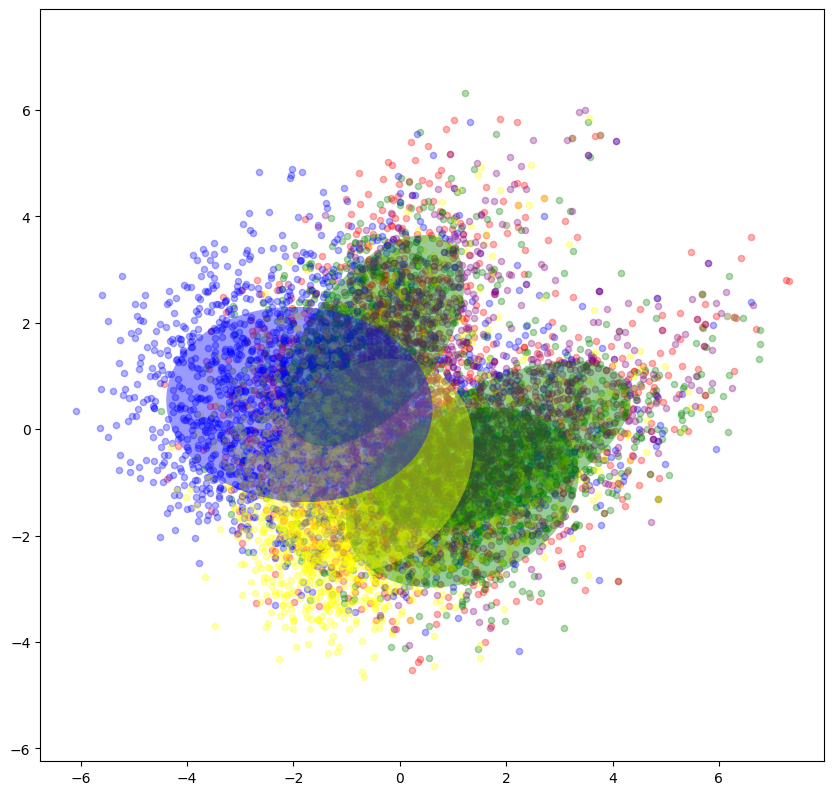

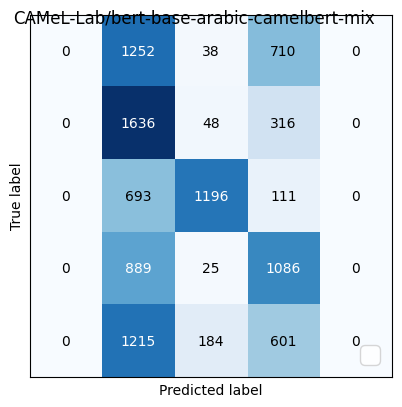

CAMeL-Lab/bert-base-arabic-camelbert-mix	39.18 (±0.00)


In [ ]:
# cluster the new split dev data
domains = ['Gulf', 'Iraq', 'Levantine', 'Nile', 'North']
first_principal = 1
last_principal = 50
num_clusters = 5
num_experiments = 1
use_pca = True

# 5 clusters - roberta-large - 88.22 (±0.49) - 1/50/5
# 10 clusters - roberta-large - 85.84 (±0.31) - 1/50/10
# 15 clusters - bert-large-cased - 87.25 (±1.19) - 1/50/15

model_to_accuracies = defaultdict(list)
for i in range(num_experiments):
    if i == num_experiments - 1:
        plot = True
        confusion = True
    else:
        plot = False
        confusion = False

    for model_name in model_to_domain_to_encodings_new:
        accuracy = fit_gmm(model_to_domain_to_encodings_new[model_name], domains,
                                first_principal_component_shown = first_principal,
                                last_principal_component_shown = last_principal,
                                clusters = num_clusters,
                                header = model_name, plot=plot, pca = use_pca, confusion=confusion)
        model_to_accuracies[model_name].append(accuracy)

for model_name in model_to_accuracies:
    print('{0}\t{1:.2f} (±{2:.2f})'.format(model_name,
                               np.mean(np.array(model_to_accuracies[model_name])),
                               np.std(np.array(model_to_accuracies[model_name]))))